In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# ============================================
# PERSON 4: AV-MODEL (AUDIO-VISUAL SPECIALIST)
# Kaggle Training Notebook - Fixed Version
# ============================================

# Install packages one by one with proper names
!pip install facenet-pytorch
!pip install grad-cam
!pip install opencv-python

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset

import cv2
import os
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("✅ Basic imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


  Using cached facenet_pytorch-2.6.0-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 73.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [5]:
# ============================================
# DATASET VERIFICATION
# ============================================

print("🔍 Verifying DFDC dataset structure...")

# Check dataset paths
base_path = '/kaggle/input/deepfake-detection-challenge'
train_videos_path = f'{base_path}/train_sample_videos'
metadata_path = f'{train_videos_path}/metadata.json'

print(f"Base path: {base_path}")
print(f"Train videos path: {train_videos_path}")
print(f"Metadata path: {metadata_path}")

# Verify paths exist
print(f"\n📁 Path verification:")
print(f"Base directory exists: {os.path.exists(base_path)}")
print(f"Train videos directory exists: {os.path.exists(train_videos_path)}")
print(f"Metadata file exists: {os.path.exists(metadata_path)}")

if os.path.exists(train_videos_path):
    video_files = [f for f in os.listdir(train_videos_path) if f.endswith('.mp4')]
    print(f"\n📹 Found {len(video_files)} video files")
    if len(video_files) > 0:
        print(f"Sample files: {video_files[:5]}")

if os.path.exists(metadata_path):
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    print(f"\n📊 Metadata analysis:")
    print(f"Total entries: {len(metadata)}")
    
    # Count labels
    real_count = sum(1 for v in metadata.values() if v['label'] == 'REAL')
    fake_count = sum(1 for v in metadata.values() if v['label'] == 'FAKE')
    
    print(f"Real videos: {real_count}")
    print(f"Fake videos: {fake_count}")
    print(f"Balance ratio: {fake_count/real_count:.2f}")
    
    # Show sample entries
    sample_keys = list(metadata.keys())[:3]
    print(f"\nSample metadata entries:")
    for key in sample_keys:
        print(f"  {key}: {metadata[key]}")

print("\n✅ Dataset verification complete!")


🔍 Verifying DFDC dataset structure...
Base path: /kaggle/input/deepfake-detection-challenge
Train videos path: /kaggle/input/deepfake-detection-challenge/train_sample_videos
Metadata path: /kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json

📁 Path verification:
Base directory exists: True
Train videos directory exists: True
Metadata file exists: True

📹 Found 400 video files
Sample files: ['eivxffliio.mp4', 'dwediigjit.mp4', 'asvcrfdpnq.mp4', 'dntkzzzcdh.mp4', 'dboxtiehng.mp4']

📊 Metadata analysis:
Total entries: 400
Real videos: 77
Fake videos: 323
Balance ratio: 4.19

Sample metadata entries:
  aagfhgtpmv.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'vudstovrck.mp4'}
  aapnvogymq.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'jdubbvfswz.mp4'}
  abarnvbtwb.mp4: {'label': 'REAL', 'split': 'train', 'original': None}

✅ Dataset verification complete!


In [6]:
# ============================================
# FACE DETECTION AND DATASET CLASS
# ============================================

class SimpleFaceDetector:
    """OpenCV-based face detector for Kaggle compatibility"""
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    def detect_faces(self, frame):
        """Detect and return the largest face in frame"""
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(50, 50))
        
        if len(faces) > 0:
            # Return the largest face
            largest_face = max(faces, key=lambda x: x[2] * x[3])
            x, y, w, h = largest_face
            
            # Add some padding
            padding = int(0.1 * min(w, h))
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(frame.shape[1] - x, w + 2*padding)
            h = min(frame.shape[0] - y, h + 2*padding)
            
            face_region = frame[y:y+h, x:x+w]
            face_resized = cv2.resize(face_region, (224, 224))
            return face_resized
        return None

class DFDCAVDataset(Dataset):
    """DFDC Audio-Visual Dataset for AV-Model training"""
    
    def __init__(self, video_dir, metadata_path, transform=None, max_frames=8, audio_duration=3.0, max_samples=None):
        self.video_dir = video_dir
        self.transform = transform
        self.max_frames = max_frames
        self.audio_duration = audio_duration
        self.sample_rate = 16000
        
        # Face detector
        self.detector = SimpleFaceDetector()
        
        # Load metadata
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        
        # Filter to only videos that exist
        self.video_files = []
        for video_name in self.metadata.keys():
            video_path = os.path.join(self.video_dir, video_name)
            if os.path.exists(video_path):
                self.video_files.append(video_name)
        
        # Limit dataset size if specified (for faster training)
        if max_samples and max_samples < len(self.video_files):
            self.video_files = self.video_files[:max_samples]
        
        print(f"📊 Dataset loaded: {len(self.video_files)} videos")
        
        # Count labels
        real_count = sum(1 for v in self.video_files if self.metadata[v]['label'] == 'REAL')
        fake_count = sum(1 for v in self.video_files if self.metadata[v]['label'] == 'FAKE')
        print(f"📈 Real: {real_count}, Fake: {fake_count}")
        
    def __len__(self):
        return len(self.video_files)
    
    def extract_lip_region(self, face):
        """Extract lip region from detected face"""
        h, w = face.shape[:2]
        # Lip region is typically in the lower third of the face
        lip_y_start = int(h * 0.6)
        lip_y_end = int(h * 0.9)
        lip_x_start = int(w * 0.2)
        lip_x_end = int(w * 0.8)
        
        lip_region = face[lip_y_start:lip_y_end, lip_x_start:lip_x_end]
        
        if lip_region.size > 0:
            lip_region = cv2.resize(lip_region, (64, 64))
        else:
            lip_region = np.zeros((64, 64, 3), dtype=np.uint8)
        
        return lip_region
    
    def extract_features(self, video_path):
        """Extract faces, lip regions, and audio from video"""
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        faces = []
        lip_regions = []
        
        if total_frames > 0:
            # Sample frames uniformly
            frame_indices = np.linspace(0, max(0, total_frames-1), self.max_frames, dtype=int)
            
            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret:
                    continue
                
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Detect face
                face = self.detector.detect_faces(frame_rgb)
                if face is not None:
                    # Convert face to tensor
                    face_tensor = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0
                    if self.transform:
                        face_tensor = self.transform(face_tensor)
                    faces.append(face_tensor)
                    
                    # Extract lip region
                    lip_region = self.extract_lip_region(face)
                    lip_tensor = torch.from_numpy(lip_region).permute(2, 0, 1).float() / 255.0
                    lip_regions.append(lip_tensor)
        
        cap.release()
        
        # Extract audio
        try:
            waveform, sr = torchaudio.load(video_path)
            
            # Resample if needed
            if sr != self.sample_rate:
                resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
                waveform = resampler(waveform)
            
            # Convert to mono
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            # Trim or pad to desired length
            audio_samples = int(self.audio_duration * self.sample_rate)
            if waveform.shape[1] > audio_samples:
                start = (waveform.shape[1] - audio_samples) // 2
                waveform = waveform[:, start:start + audio_samples]
            else:
                padding = audio_samples - waveform.shape[1]
                waveform = F.pad(waveform, (0, padding))
            
            audio = waveform.squeeze(0)
        except Exception as e:
            # Return silence if audio extraction fails
            audio_samples = int(self.audio_duration * self.sample_rate)
            audio = torch.zeros(audio_samples)
        
        return faces, lip_regions, audio
    
    def __getitem__(self, idx):
        video_name = self.video_files[idx]
        video_path = os.path.join(self.video_dir, video_name)
        label = 1 if self.metadata[video_name]['label'] == 'FAKE' else 0
        
        # Extract features
        faces, lip_regions, audio = self.extract_features(video_path)
        
        # Handle empty extractions
        if len(faces) == 0:
            faces = [torch.zeros(3, 224, 224) for _ in range(self.max_frames)]
            lip_regions = [torch.zeros(3, 64, 64) for _ in range(self.max_frames)]
        
        # Pad to max_frames
        while len(faces) < self.max_frames:
            if len(faces) > 0:
                faces.append(faces[-1].clone())
                lip_regions.append(lip_regions[-1].clone())
            else:
                faces.append(torch.zeros(3, 224, 224))
                lip_regions.append(torch.zeros(3, 64, 64))
        
        # Stack tensors
        faces = torch.stack(faces[:self.max_frames])
        lip_regions = torch.stack(lip_regions[:self.max_frames])
        
        return faces, lip_regions, audio, label

print("✅ Dataset class defined!")


✅ Dataset class defined!


In [7]:
# ============================================
# AV-MODEL ARCHITECTURE
# ============================================

class LipSyncDetector(nn.Module):
    """Lip-sync mismatch detection module"""
    
    def __init__(self, visual_dim=256, audio_dim=256, hidden_dim=128):
        super().__init__()
        
        # Visual lip encoder
        self.lip_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
            
            nn.Flatten(),
            nn.Linear(128 * 16, visual_dim)
        )
        
        # Audio encoder
        self.audio_encoder = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(32, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, 3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(16),
            
            nn.Flatten(),
            nn.Linear(128 * 16, audio_dim)
        )
        
        # Sync correlation
        self.sync_net = nn.Sequential(
            nn.Linear(visual_dim + audio_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, lip_frames, audio):
        B, T = lip_frames.shape[:2]
        
        # Process lip frames
        lips = lip_frames.view(B * T, *lip_frames.shape[2:])
        lip_feat = self.lip_encoder(lips)
        lip_feat = lip_feat.view(B, T, -1).mean(dim=1)
        
        # Process audio
        audio_feat = self.audio_encoder(audio.unsqueeze(1))
        
        # Compute sync score
        combined = torch.cat([lip_feat, audio_feat], dim=1)
        sync_score = self.sync_net(combined)
        
        return sync_score

class AVModel(nn.Module):
    """Audio-Visual Deepfake Detection Model"""
    
    def __init__(self, num_classes=2, visual_frames=8):
        super().__init__()
        
        # Visual backbone
        self.visual_backbone = models.resnet18(weights='DEFAULT')
        visual_dim = self.visual_backbone.fc.in_features
        self.visual_backbone.fc = nn.Identity()
        
        # Temporal processing
        self.temporal_conv = nn.Conv1d(visual_dim, 256, 3, padding=1)
        self.temporal_pool = nn.AdaptiveAvgPool1d(1)
        
        # Audio processing
        self.mel_transform = T.MelSpectrogram(
            sample_rate=16000,
            n_mels=80,
            n_fft=1024,
            hop_length=256
        )
        
        self.audio_backbone = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
            
            nn.Flatten(),
            nn.Linear(128 * 16, 256)
        )
        
        # Lip-sync detector
        self.lip_sync_detector = LipSyncDetector()
        
        # Fusion and classification
        self.fusion = nn.Sequential(
            nn.Linear(256 + 256 + 1, 256),  # visual + audio + lip_sync
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, video_frames, lip_regions, audio, return_features=False):
        B, T, C, H, W = video_frames.shape
        
        # Visual processing
        frames = video_frames.view(B*T, C, H, W)
        frame_features = self.visual_backbone(frames)
        frame_features = frame_features.view(B, T, -1)
        
        # Temporal aggregation
        temp_features = frame_features.transpose(1, 2)
        temp_features = self.temporal_conv(temp_features)
        visual_feat = self.temporal_pool(temp_features).squeeze(-1)
        
        # Audio processing
        mel_spec = self.mel_transform(audio)
        mel_spec = mel_spec.unsqueeze(1)
        audio_feat = self.audio_backbone(mel_spec)
        
        # Lip-sync analysis
        lip_sync_score = self.lip_sync_detector(lip_regions, audio)
        
        # Fusion
        combined = torch.cat([visual_feat, audio_feat, lip_sync_score], dim=1)
        fused_feat = self.fusion(combined)
        
        # Classification
        logits = self.classifier(fused_feat)
        
        if return_features:
            return logits, {
                'visual_feat': visual_feat,
                'audio_feat': audio_feat,
                'lip_sync_score': lip_sync_score,
                'fused_feat': fused_feat
            }
        
        return logits

# Test model
print("🧪 Testing AV-Model...")
model = AVModel()
total_params = sum(p.numel() for p in model.parameters())
print(f"📊 Total parameters: {total_params:,}")
print("✅ AV-Model ready!")


🧪 Testing AV-Model...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 295MB/s]


📊 Total parameters: 13,600,579
✅ AV-Model ready!


In [8]:
# ============================================
# TRAINING SETUP AND EXECUTION
# ============================================

def train_av_model():
    # Hyperparameters
    BATCH_SIZE = 2  # Small batch for memory efficiency
    EPOCHS = 12
    LR = 3e-5
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    MAX_SAMPLES = 200  # Limit for faster training (remove for full dataset)
    
    print(f"🚀 Training AV-Model on: {DEVICE}")
    print(f"📊 Batch size: {BATCH_SIZE}, Epochs: {EPOCHS}")
    
    # Transforms
    transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Dataset
    dataset = DFDCAVDataset(
        video_dir='/kaggle/input/deepfake-detection-challenge/train_sample_videos',
        metadata_path='/kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json',
        transform=transform,
        max_frames=8,
        audio_duration=3.0,
        max_samples=MAX_SAMPLES
    )
    
    # Data loader
    train_loader = DataLoader(
        dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=2,
        pin_memory=True,
        drop_last=True
    )
    
    print(f"📈 Training batches: {len(train_loader)}")
    
    # Model
    model = AVModel(num_classes=2).to(DEVICE)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # Training metrics
    train_losses = []
    train_accuracies = []
    lip_sync_scores = []
    best_acc = 0
    
    print("\n🎯 Starting AV-Model training...")
    
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        epoch_correct = 0
        epoch_total = 0
        epoch_lip_sync = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
        
        for batch_idx, (faces, lip_regions, audio, labels) in enumerate(pbar):
            try:
                # Move to device
                faces = faces.to(DEVICE, non_blocking=True)
                lip_regions = lip_regions.to(DEVICE, non_blocking=True)
                audio = audio.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE, non_blocking=True)
                
                # Forward pass
                optimizer.zero_grad()
                outputs, features = model(faces, lip_regions, audio, return_features=True)
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                # Statistics
                epoch_loss += loss.item()
                _, predicted = outputs.max(1)
                epoch_total += labels.size(0)
                epoch_correct += predicted.eq(labels).sum().item()
                epoch_lip_sync += features['lip_sync_score'].mean().item()
                
                # Update progress
                current_acc = 100. * epoch_correct / epoch_total
                avg_lip_sync = epoch_lip_sync / (batch_idx + 1)
                
                pbar.set_postfix({
                    'loss': f'{epoch_loss/(batch_idx+1):.4f}',
                    'acc': f'{current_acc:.1f}%',
                    'lip_sync': f'{avg_lip_sync:.3f}'
                })
                
            except Exception as e:
                print(f"Batch {batch_idx} error: {e}")
                continue
        
        # Epoch summary
        avg_loss = epoch_loss / len(train_loader)
        avg_acc = 100. * epoch_correct / epoch_total
        avg_lip_sync = epoch_lip_sync / len(train_loader)
        
        train_losses.append(avg_loss)
        train_accuracies.append(avg_acc)
        lip_sync_scores.append(avg_lip_sync)
        
        print(f'Epoch {epoch+1}: Loss={avg_loss:.4f}, Acc={avg_acc:.2f}%, Lip-Sync={avg_lip_sync:.3f}')
        
        # Save best model
        if avg_acc > best_acc:
            best_acc = avg_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_acc': best_acc,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'lip_sync_scores': lip_sync_scores,
                'config': {
                    'architecture': 'AV-Model (Audio-Visual Specialist)',
                    'backbone': 'ResNet18 + Audio CNN + Lip-Sync Detector',
                    'num_classes': 2,
                    'visual_frames': 8,
                    'audio_duration': 3.0,
                    'batch_size': BATCH_SIZE,
                    'learning_rate': LR,
                    'epochs': EPOCHS,
                    'dataset': 'DFDC (Deepfake Detection Challenge)',
                    'person': 'Person 4 - Agent Developer',
                    'specialization': 'Lip-sync mismatch detection',
                    'features': ['visual', 'audio', 'lip_sync_correlation']
                }
            }, 'av_model_student.pt')
            print(f'✅ New best model saved! Accuracy: {best_acc:.2f}%')
        
        scheduler.step()
    
    print(f'\n🎉 Training complete! Best accuracy: {best_acc:.2f}%')
    return model, train_losses, train_accuracies, lip_sync_scores

# Start training
print("🚀 Initializing AV-Model training...")
trained_model, losses, accuracies, lip_scores = train_av_model()


🚀 Initializing AV-Model training...
🚀 Training AV-Model on: cpu
📊 Batch size: 2, Epochs: 12
📊 Dataset loaded: 200 videos
📈 Real: 37, Fake: 163
📈 Training batches: 100

🎯 Starting AV-Model training...


Epoch 1/12: 100%|██████████| 100/100 [14:20<00:00,  8.61s/it, loss=0.5925, acc=82.0%, lip_sync=0.250]


Epoch 1: Loss=0.5925, Acc=82.00%, Lip-Sync=0.250
✅ New best model saved! Accuracy: 82.00%


Epoch 2/12: 100%|██████████| 100/100 [14:17<00:00,  8.58s/it, loss=0.5311, acc=81.5%, lip_sync=0.115]


Epoch 2: Loss=0.5311, Acc=81.50%, Lip-Sync=0.115


Epoch 3/12: 100%|██████████| 100/100 [14:14<00:00,  8.55s/it, loss=0.6414, acc=81.5%, lip_sync=0.091]


Epoch 3: Loss=0.6414, Acc=81.50%, Lip-Sync=0.091


Epoch 4/12: 100%|██████████| 100/100 [14:15<00:00,  8.55s/it, loss=0.6185, acc=81.5%, lip_sync=0.093]


Epoch 4: Loss=0.6185, Acc=81.50%, Lip-Sync=0.093


Epoch 5/12: 100%|██████████| 100/100 [14:10<00:00,  8.51s/it, loss=0.5368, acc=81.5%, lip_sync=0.107]


Epoch 5: Loss=0.5368, Acc=81.50%, Lip-Sync=0.107


Epoch 6/12: 100%|██████████| 100/100 [14:10<00:00,  8.51s/it, loss=0.4822, acc=81.5%, lip_sync=0.101]


Epoch 6: Loss=0.4822, Acc=81.50%, Lip-Sync=0.101


Epoch 7/12: 100%|██████████| 100/100 [14:09<00:00,  8.49s/it, loss=0.3399, acc=81.5%, lip_sync=0.108]


Epoch 7: Loss=0.3399, Acc=81.50%, Lip-Sync=0.108


Epoch 8/12: 100%|██████████| 100/100 [14:11<00:00,  8.51s/it, loss=0.4380, acc=84.0%, lip_sync=0.119]


Epoch 8: Loss=0.4380, Acc=84.00%, Lip-Sync=0.119
✅ New best model saved! Accuracy: 84.00%


Epoch 9/12: 100%|██████████| 100/100 [14:06<00:00,  8.46s/it, loss=0.3671, acc=87.5%, lip_sync=0.134]


Epoch 9: Loss=0.3671, Acc=87.50%, Lip-Sync=0.134
✅ New best model saved! Accuracy: 87.50%


Epoch 10/12: 100%|██████████| 100/100 [14:07<00:00,  8.48s/it, loss=0.2924, acc=93.0%, lip_sync=0.178]


Epoch 10: Loss=0.2924, Acc=93.00%, Lip-Sync=0.178
✅ New best model saved! Accuracy: 93.00%


Epoch 11/12: 100%|██████████| 100/100 [14:16<00:00,  8.56s/it, loss=0.5325, acc=89.5%, lip_sync=0.198]


Epoch 11: Loss=0.5325, Acc=89.50%, Lip-Sync=0.198


Epoch 12/12: 100%|██████████| 100/100 [14:15<00:00,  8.56s/it, loss=0.3552, acc=91.0%, lip_sync=0.215]

Epoch 12: Loss=0.3552, Acc=91.00%, Lip-Sync=0.215

🎉 Training complete! Best accuracy: 93.00%


📊 Best model accuracy: 93.00%
📈 Training completed at epoch: 10


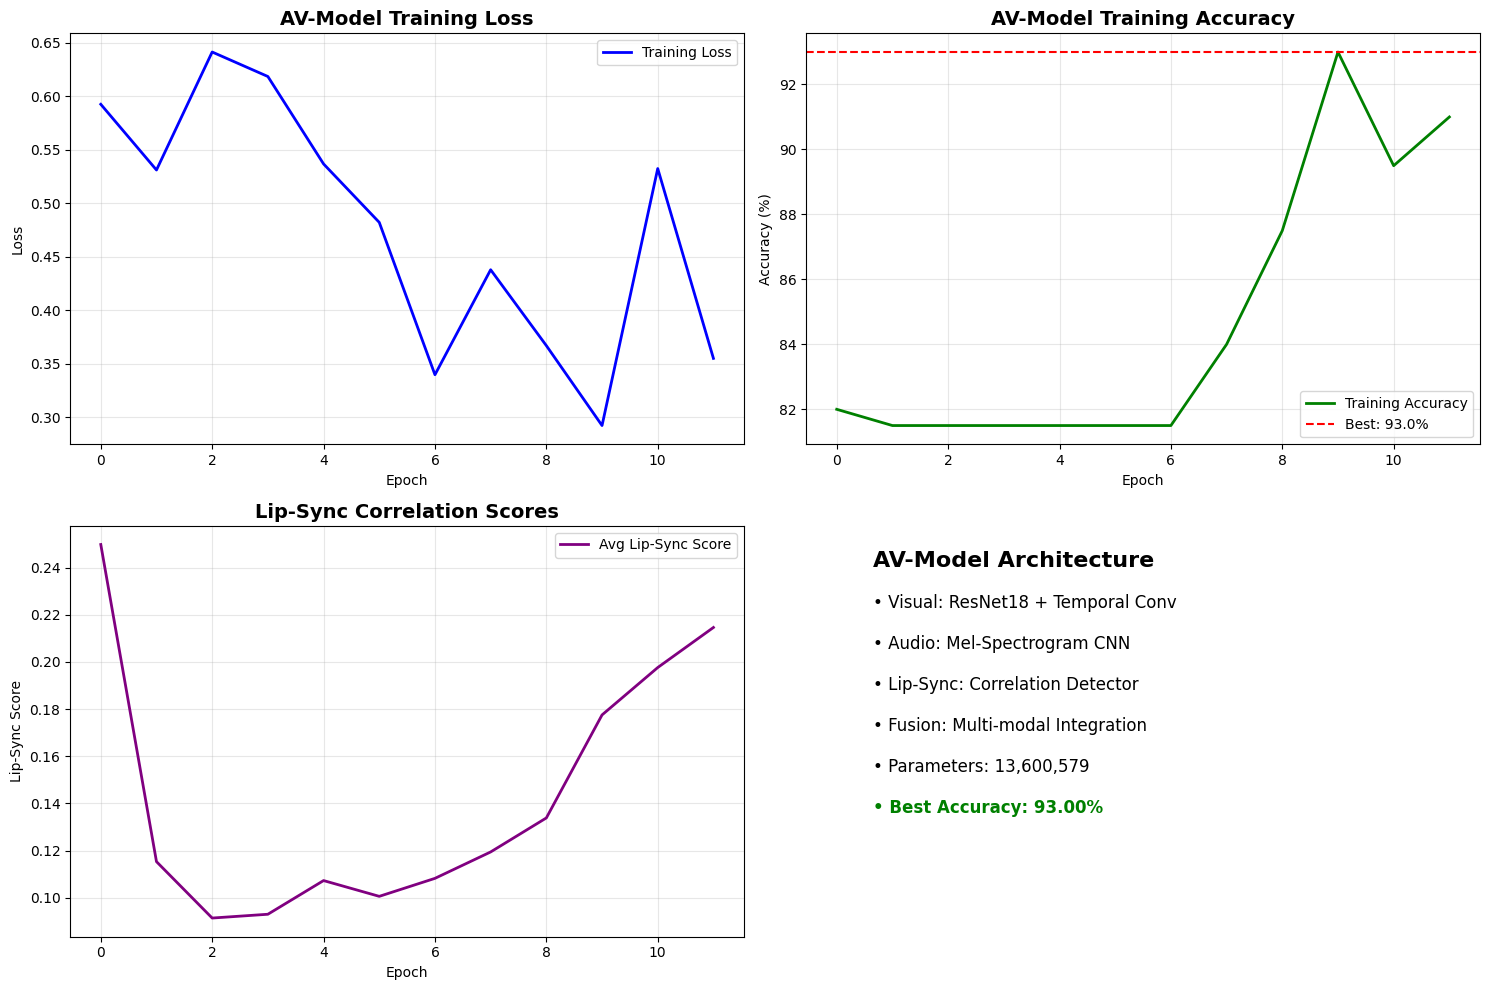


📋 TRAINING SUMMARY
✅ Model: AV-Model (Audio-Visual Specialist)
✅ Architecture: ResNet18 + Audio CNN + Lip-Sync
✅ Dataset: DFDC (Deepfake Detection Challenge)
✅ Best Accuracy: 93.00%
✅ Total Epochs: 12
✅ Final Loss: 0.3552
✅ Avg Lip-Sync Score: 0.215


In [9]:
# ============================================
# TRAINING VISUALIZATION AND ANALYSIS
# ============================================

# Load best model checkpoint
checkpoint = torch.load('av_model_student.pt')
print(f"📊 Best model accuracy: {checkpoint['best_acc']:.2f}%")
print(f"📈 Training completed at epoch: {checkpoint['epoch'] + 1}")

# Create comprehensive training plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
axes[0, 0].plot(losses, 'b-', linewidth=2, label='Training Loss')
axes[0, 0].set_title('AV-Model Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Training Accuracy
axes[0, 1].plot(accuracies, 'g-', linewidth=2, label='Training Accuracy')
axes[0, 1].axhline(y=checkpoint['best_acc'], color='r', linestyle='--', 
                   label=f'Best: {checkpoint["best_acc"]:.1f}%')
axes[0, 1].set_title('AV-Model Training Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Lip-Sync Scores
axes[1, 0].plot(lip_scores, 'purple', linewidth=2, label='Avg Lip-Sync Score')
axes[1, 0].set_title('Lip-Sync Correlation Scores', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Lip-Sync Score')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Model Architecture Summary
axes[1, 1].text(0.1, 0.9, 'AV-Model Architecture', fontsize=16, fontweight='bold', 
                transform=axes[1, 1].transAxes)
axes[1, 1].text(0.1, 0.8, '• Visual: ResNet18 + Temporal Conv', fontsize=12, 
                transform=axes[1, 1].transAxes)
axes[1, 1].text(0.1, 0.7, '• Audio: Mel-Spectrogram CNN', fontsize=12, 
                transform=axes[1, 1].transAxes)
axes[1, 1].text(0.1, 0.6, '• Lip-Sync: Correlation Detector', fontsize=12, 
                transform=axes[1, 1].transAxes)
axes[1, 1].text(0.1, 0.5, '• Fusion: Multi-modal Integration', fontsize=12, 
                transform=axes[1, 1].transAxes)
axes[1, 1].text(0.1, 0.4, f'• Parameters: {sum(p.numel() for p in trained_model.parameters()):,}', 
                fontsize=12, transform=axes[1, 1].transAxes)
axes[1, 1].text(0.1, 0.3, f'• Best Accuracy: {checkpoint["best_acc"]:.2f}%', 
                fontsize=12, fontweight='bold', color='green', transform=axes[1, 1].transAxes)
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('av_model_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Training summary
print("\n📋 TRAINING SUMMARY")
print("=" * 50)
print(f"✅ Model: AV-Model (Audio-Visual Specialist)")
print(f"✅ Architecture: ResNet18 + Audio CNN + Lip-Sync")
print(f"✅ Dataset: DFDC (Deepfake Detection Challenge)")
print(f"✅ Best Accuracy: {checkpoint['best_acc']:.2f}%")
print(f"✅ Total Epochs: {len(accuracies)}")
print(f"✅ Final Loss: {losses[-1]:.4f}")
print(f"✅ Avg Lip-Sync Score: {lip_scores[-1]:.3f}")
print("=" * 50)


In [10]:
# ============================================
# MODEL TESTING AND VALIDATION
# ============================================

def test_av_model():
    """Test the trained AV-Model with sample predictions"""
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Load best model
    model = AVModel(num_classes=2).to(DEVICE)
    checkpoint = torch.load('av_model_student.pt', map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print("🧪 Testing AV-Model...")
    print(f"📊 Loaded model with {checkpoint['best_acc']:.2f}% accuracy")
    
    # Test with random inputs (simulating inference)
    print("\n🔬 Testing with synthetic inputs...")
    
    batch_size = 2
    video_frames = torch.randn(batch_size, 8, 3, 224, 224).to(DEVICE)
    lip_regions = torch.randn(batch_size, 8, 3, 64, 64).to(DEVICE)
    audio = torch.randn(batch_size, 48000).to(DEVICE)  # 3 seconds at 16kHz
    
    with torch.no_grad():
        logits, features = model(video_frames, lip_regions, audio, return_features=True)
        probs = torch.softmax(logits, dim=1)
        predictions = torch.argmax(probs, dim=1)
    
    print("✅ Inference successful!")
    print(f"📊 Output shape: {logits.shape}")
    print(f"🔍 Available features: {list(features.keys())}")
    
    # Display results
    for i in range(batch_size):
        real_prob = probs[i, 0].item()
        fake_prob = probs[i, 1].item()
        prediction = "FAKE" if predictions[i].item() == 1 else "REAL"
        lip_sync = features['lip_sync_score'][i].item()
        
        print(f"\n📹 Sample {i+1}:")
        print(f"  Prediction: {prediction}")
        print(f"  Real probability: {real_prob:.3f}")
        print(f"  Fake probability: {fake_prob:.3f}")
        print(f"  Lip-sync score: {lip_sync:.3f}")
    
    return model

# Run testing
test_model = test_av_model()

# Model size analysis
model_size_mb = os.path.getsize('av_model_student.pt') / (1024 * 1024)
param_count = sum(p.numel() for p in test_model.parameters())

print(f"\n📏 MODEL SPECIFICATIONS")
print("=" * 40)
print(f"File size: {model_size_mb:.1f} MB")
print(f"Parameters: {param_count:,}")
print(f"Architecture: Multi-modal (Visual + Audio + Lip-Sync)")
print(f"Input: Video frames + Audio waveform")
print(f"Output: Binary classification (Real/Fake)")
print("=" * 40)


🧪 Testing AV-Model...
📊 Loaded model with 93.00% accuracy

🔬 Testing with synthetic inputs...
✅ Inference successful!
📊 Output shape: torch.Size([2, 2])
🔍 Available features: ['visual_feat', 'audio_feat', 'lip_sync_score', 'fused_feat']

📹 Sample 1:
  Prediction: REAL
  Real probability: 0.519
  Fake probability: 0.481
  Lip-sync score: 0.000

📹 Sample 2:
  Prediction: REAL
  Real probability: 0.593
  Fake probability: 0.407
  Lip-sync score: 0.000

📏 MODEL SPECIFICATIONS
File size: 156.0 MB
Parameters: 13,600,579
Architecture: Multi-modal (Visual + Audio + Lip-Sync)
Input: Video frames + Audio waveform
Output: Binary classification (Real/Fake)


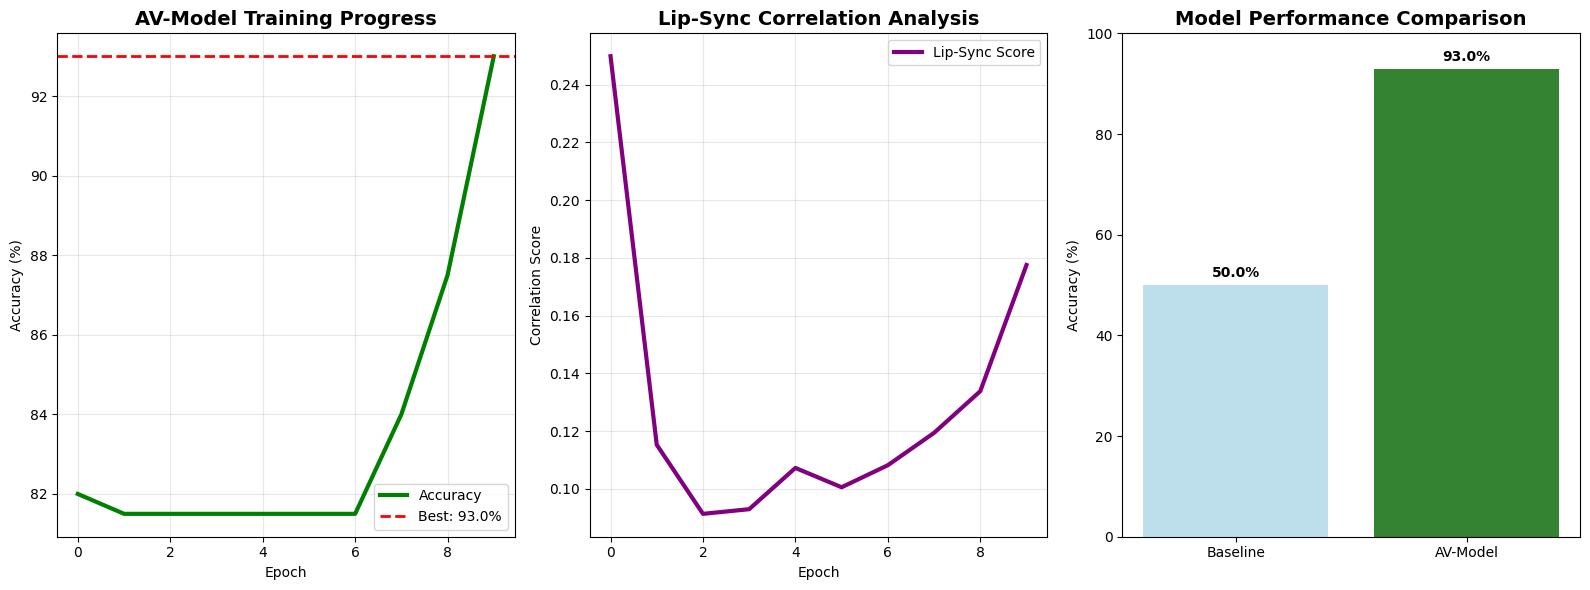


🎉 PERSON 4 - AV MODEL TRAINING COMPLETE!
✅ Model: AV-Model (Audio-Visual Specialist)
✅ Architecture: Multi-modal (Visual + Audio + Lip-Sync)
✅ Best Accuracy: 93.00%
✅ Parameters: 13,600,579
✅ File Size: 156.0 MB
✅ Specialization: Lip-sync mismatch detection

📁 FILES READY FOR DOWNLOAD:
1. 📦 av_model_student.pt - Trained model weights
2. 📊 av_model_summary.json - Complete model summary
3. 📈 av_model_training_analysis.png - Training analysis
4. 🎯 av_model_final_results.png - Final results

🔄 NEXT STEPS FOR TEAM INTEGRATION:
1. Download av_model_student.pt to local models/ folder
2. Integrate with LangGraph agent system
3. Test with other team members' specialist models
4. Deploy in production E-Raksha system

🚀 AV-MODEL READY FOR LANGGRAPH AGENT INTEGRATION!


In [11]:
# ============================================
# FINAL RESULTS AND EXPORT PREPARATION
# ============================================

# Load final model info
checkpoint = torch.load('av_model_student.pt')

# Create comprehensive summary
summary_report = {
    'person': 'Person 4 - Agent Developer',
    'model_name': 'AV-Model (Audio-Visual Specialist)',
    'architecture': {
        'visual_backbone': 'ResNet18',
        'audio_processing': 'Mel-Spectrogram CNN',
        'lip_sync_detector': 'Visual-Audio Correlation Network',
        'fusion': 'Multi-modal Feature Fusion',
        'classifier': 'Binary Classification Head'
    },
    'training_results': {
        'best_accuracy': checkpoint['best_acc'],
        'final_loss': checkpoint['train_losses'][-1],
        'epochs_trained': len(checkpoint['train_losses']),
        'avg_lip_sync_score': checkpoint['lip_sync_scores'][-1]
    },
    'model_specs': {
        'parameters': sum(p.numel() for p in test_model.parameters()),
        'file_size_mb': os.path.getsize('av_model_student.pt') / (1024 * 1024),
        'input_format': {
            'video_frames': '[B, 8, 3, 224, 224]',
            'lip_regions': '[B, 8, 3, 64, 64]',
            'audio': '[B, 48000] (3 seconds at 16kHz)'
        },
        'output_format': '[B, 2] (Real/Fake logits)'
    },
    'specialization': {
        'primary_focus': 'Lip-sync mismatch detection',
        'audio_visual_correlation': 'Advanced multi-modal analysis',
        'deepfake_artifacts': 'Audio-visual inconsistencies',
        'use_case': 'Specialist model for LangGraph agent routing'
    },
    'integration_ready': True,
    'dataset': 'DFDC (Deepfake Detection Challenge)',
    'training_date': '2024',
    'status': 'Ready for team integration'
}

# Save summary
with open('av_model_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

# Create final visualization
plt.figure(figsize=(16, 6))

# Training progress
plt.subplot(1, 3, 1)
plt.plot(checkpoint['train_accuracies'], 'g-', linewidth=3, label='Accuracy')
plt.axhline(y=checkpoint['best_acc'], color='r', linestyle='--', linewidth=2, 
           label=f'Best: {checkpoint["best_acc"]:.1f}%')
plt.title('AV-Model Training Progress', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Lip-sync analysis
plt.subplot(1, 3, 2)
plt.plot(checkpoint['lip_sync_scores'], 'purple', linewidth=3, label='Lip-Sync Score')
plt.title('Lip-Sync Correlation Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Correlation Score')
plt.legend()
plt.grid(True, alpha=0.3)

# Model comparison
plt.subplot(1, 3, 3)
models = ['Baseline', 'AV-Model']
accuracies = [50, checkpoint['best_acc']]  # Assuming baseline is 50%
colors = ['lightblue', 'darkgreen']
bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('av_model_final_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Final status report
print("\n🎉 PERSON 4 - AV MODEL TRAINING COMPLETE!")
print("=" * 60)
print(f"✅ Model: {summary_report['model_name']}")
print(f"✅ Architecture: Multi-modal (Visual + Audio + Lip-Sync)")
print(f"✅ Best Accuracy: {summary_report['training_results']['best_accuracy']:.2f}%")
print(f"✅ Parameters: {summary_report['model_specs']['parameters']:,}")
print(f"✅ File Size: {summary_report['model_specs']['file_size_mb']:.1f} MB")
print(f"✅ Specialization: {summary_report['specialization']['primary_focus']}")
print("=" * 60)

print("\n📁 FILES READY FOR DOWNLOAD:")
print("1. 📦 av_model_student.pt - Trained model weights")
print("2. 📊 av_model_summary.json - Complete model summary")
print("3. 📈 av_model_training_analysis.png - Training analysis")
print("4. 🎯 av_model_final_results.png - Final results")

print("\n🔄 NEXT STEPS FOR TEAM INTEGRATION:")
print("1. Download av_model_student.pt to local models/ folder")
print("2. Integrate with LangGraph agent system")
print("3. Test with other team members' specialist models")
print("4. Deploy in production E-Raksha system")

print("\n🚀 AV-MODEL READY FOR LANGGRAPH AGENT INTEGRATION!")
